In [1]:
# Custom Imports
from typing import Union
import sys
sys.path.append("../..")
sys.path.append("..")
import data_utils
import GradCertModule
import XAIArchitectures
# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pytorch_lightning as pl
# Standard Lib Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 0
import numpy as np
import random
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

dataset = "GERMAN"

if(dataset == "GERMAN"):
    negative_cls = 0
    sensitive_features = [] 
    sens = ['status_sex_A91', 'status_sex_A92', 'status_sex_A93', 'status_sex_A94']
    drop_columns = []
    train_ds, test_ds = data_utils.get_german_data(sensitive_features, drop_columns=drop_columns)

elif(dataset == "CREDIT"):
    negative_cls = 1
    sensitive_features = [] 
    sens = ['x2_1.0', 'x2_2.0']
    drop_columns = []
    train_ds, test_ds = data_utils.get_credit_data(sensitive_features, drop_columns=drop_columns)
    
elif(dataset == "ADULT"):
    negative_cls = 1
    sensitive_features = [] 
    sens = ['sex_Female', 'sex_Male', 'race_Amer-Indian-Eskimo', 
            'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',]
    drop_columns = ['native-country'] #, 'education']
    train_ds, test_ds = data_utils.get_adult_data(sensitive_features, drop_columns=drop_columns)
    
elif(dataset == "CRIME"):
    negative_cls = 1
    CRIME_DROP_COLUMNS = [
    'HispPerCap', 'LandArea', 'LemasPctOfficDrugUn', 'MalePctNevMarr',
    'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'MedRent',
    'MedYrHousBuilt', 'OwnOccHiQuart', 'OwnOccLowQuart',
    'OwnOccMedVal', 'PctBornSameState', 'PctEmplManu',
    'PctEmplProfServ', 'PctEmploy', 'PctForeignBorn', 'PctImmigRec5',
    'PctImmigRec8', 'PctImmigRecent', 'PctRecImmig10', 'PctRecImmig5',
    'PctRecImmig8', 'PctRecentImmig', 'PctSameCity85',
    'PctSameState85', 'PctSpeakEnglOnly', 'PctUsePubTrans',
    'PctVacMore6Mos', 'PctWorkMom', 'PctWorkMomYoungKids',
    'PersPerFam', 'PersPerOccupHous', 'PersPerOwnOccHous',
    'PersPerRentOccHous', 'RentHighQ', 'RentLowQ', 'Unnamed: 0',
    'agePct12t21', 'agePct65up', 'householdsize', 'indianPerCap',
    'pctUrban', 'pctWFarmSelf', 'pctWRetire', 'pctWSocSec', 'pctWWage',
    'whitePerCap'
    ]
    sensitive_features = []
    sens = ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']
    train_ds, test_ds = data_utils.get_crime_data(sensitive_features, drop_columns=CRIME_DROP_COLUMNS)

In [2]:
#print(train_ds.X_df.columns.tolist())
cols = train_ds.X_df.columns.tolist()
print(cols)
sens_inds = []
for i in sens:
    sens_inds.append(cols.index(i))
#print(sens_inds)

if(dataset == "ADULT"):
    AGE = [cols.index('age')]
    RACE = [cols.index(i) for i in ['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White']]
    GENDER = [cols.index(i) for i in ['sex_Female', 'sex_Male']]
    FINANCES = [cols.index(i) for i in ['capital-gain', 'capital-loss']]
    EDUCATION = [cols.index(i) for i in ['education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 
                                         'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters',
                                         'education_Preschool', 'education_Prof-school', 'education_Some-college']]     
    EMPLOYMENT = [cols.index(i) for i in ['hours-per-week', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 
                                          'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct', 'occupation_Other-service', 'occupation_Priv-house-serv', 'occupation_Prof-specialty', 
                                          'occupation_Protective-serv', 'occupation_Sales', 'occupation_Tech-support', 'occupation_Transport-moving', 'workclass_Local-gov', 'workclass_Private',
                                          'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay']]          
    PERSONAL = [cols.index(i) for i in ['hours-per-week', 'relationship_Husband', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'marital-status_Divorced',
                                        'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed']]
                           
elif(dataset == "CREDIT"):
    AMOUNT = [cols.index('x1')]
    AGE = [cols.index(i) for i in [ 'x5_21.0', 'x5_22.0', 'x5_23.0', 'x5_24.0', 'x5_25.0', 'x5_26.0', 'x5_27.0', 'x5_28.0', 'x5_29.0', 'x5_30.0', 'x5_31.0', 
                                   'x5_32.0', 'x5_33.0', 'x5_34.0', 'x5_35.0', 'x5_36.0', 'x5_37.0', 'x5_38.0', 'x5_39.0', 'x5_40.0', 'x5_41.0', 'x5_42.0', 
                                   'x5_43.0', 'x5_44.0', 'x5_45.0', 'x5_46.0', 'x5_47.0', 'x5_48.0', 'x5_49.0', 'x5_50.0', 'x5_51.0', 'x5_52.0', 'x5_53.0', 
                                   'x5_54.0', 'x5_55.0', 'x5_56.0', 'x5_57.0', 'x5_58.0', 'x5_59.0', 'x5_60.0', 'x5_61.0', 'x5_62.0', 'x5_63.0', 'x5_64.0', 
                                   'x5_65.0', 'x5_66.0', 'x5_67.0', 'x5_68.0', 'x5_69.0', 'x5_70.0', 'x5_71.0', 'x5_72.0', 'x5_73.0', 'x5_74.0', 'x5_75.0', 
                                   'x5_79.0']]
    GENDER = [cols.index(i) for i in ['x2_1.0', 'x2_2.0']]
    EDUCATION = [cols.index(i) for i in ['x2_1.0', 'x2_2.0']]
    PERSONAL = [cols.index(i) for i in ['x4_0.0', 'x4_1.0', 'x4_2.0', 'x4_3.0']]
    BILLS = [cols.index(i) for i in ['x12', 'x13', 'x14', 'x15', 'x16', 'x17']]
    PAYMENTS = [cols.index(i) for i in ['x6_-1.0', 'x6_-2.0', 'x6_0.0', 'x6_1.0', 'x6_2.0', 'x6_3.0', 'x6_4.0', 'x6_5.0', 'x6_6.0', 'x6_7.0', 'x6_8.0', 
                                        'x7_-1.0', 'x7_-2.0', 'x7_0.0', 'x7_1.0', 'x7_2.0', 'x7_3.0', 'x7_4.0', 'x7_5.0', 'x7_6.0', 'x7_7.0', 'x7_8.0', 
                                        'x8_-1.0', 'x8_-2.0', 'x8_0.0', 'x8_1.0', 'x8_2.0', 'x8_3.0', 'x8_4.0', 'x8_5.0', 'x8_6.0', 'x8_7.0', 'x8_8.0', 
                                        'x9_-1.0', 'x9_-2.0', 'x9_0.0', 'x9_1.0', 'x9_2.0', 'x9_3.0', 'x9_4.0', 'x9_5.0', 'x9_6.0', 'x9_7.0', 'x9_8.0', 
                                        'x10_-1.0', 'x10_-2.0', 'x10_0.0', 'x10_2.0', 'x10_3.0', 'x10_4.0', 'x10_5.0', 'x10_6.0', 'x10_7.0', 'x10_8.0', 
                                        'x11_-1.0', 'x11_-2.0', 'x11_0.0', 'x11_2.0', 'x11_3.0', 'x11_4.0', 'x11_5.0', 'x11_6.0', 'x11_7.0', 'x11_8.0',
                                        'x18', 'x19', 'x20', 'x21', 'x22', 'x23']]
                           

['Unnamed: 0', 'age', 'credit_amount', 'credits_num', 'dependants_num', 'duration', 'installment_rate_pct', 'residence_since', 'account_status_A11', 'account_status_A12', 'account_status_A13', 'account_status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'employment_A71', 'employment_A72', 'employment_A73', 'employment_A74', 'employment_A75', 'foreign_A201', 'foreign_A202', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'other_installment_plans_A141', 'other_installment_plans_A142', 'other_installment_plans_A143', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_account_A61', 'savings_account_A62', 'savings_accoun

In [3]:
X_train = train_ds.X_df.to_numpy()
y_train = torch.squeeze(torch.Tensor(train_ds.y_df.to_numpy()).to(torch.int64))

X_test = test_ds.X_df.to_numpy()
y_test = torch.squeeze(torch.Tensor(test_ds.y_df.to_numpy()).to(torch.int64))

In [4]:

class custDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).float()
        self.y = y
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

CustTrain = custDataset(X_train, y_train)    
CustTest = custDataset(X_test, y_test)

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train, val, test, batch_size=32):
        super().__init__()
        self.train_data = train
        self.val_data = val
        self.test_data = test
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)
    
dm = CustomDataModule(CustTrain, CustTest, CustTest)

In [5]:
ALPHA = 1.0            # Regularization Parameter (Weights the Reg. Term)
EPSILON = 0.0          # Input Peturbation Budget at Training Time
GAMMA = 0.0            # Model Peturbation Budget at Training Time 
                       #(Changed to proportional budget rather than absolute)
    
LEARN_RATE = 0.0005     # Learning Rate Hyperparameter
HIDDEN_DIM = 256       # Hidden Neurons Hyperparameter
HIDDEN_LAY = 2         # Hidden Layers Hyperparameter
MAX_EPOCHS = 25

EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?

In [6]:

model = XAIArchitectures.FullyConnected(hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY, dataset=dataset)
model.set_params(alpha=ALPHA, epsilon=EPSILON, gamma=GAMMA, 
                learn_rate=LEARN_RATE, max_epochs=MAX_EPOCHS,
                epsilon_linear=EPSILON_LINEAR, gamma_linear=GAMMA_LINEAR)


SET MODE TO:  GRAD


In [7]:

SCHEDULED = EPSILON_LINEAR or GAMMA_LINEAR    
#MODEL_ID = "FCN_e=%s_g=%s_h=%s_l=%s_s=%s"%(EPSILON, GAMMA, HIDDEN_DIM, HIDDEN_LAY, SCHEDULED)  
MODEL_ID = "%s_FCN_e=%s_g=%s_a=%s_l=%s_h=%s_s=%s"%(dataset, EPSILON, GAMMA, ALPHA, HIDDEN_LAY, HIDDEN_DIM, SCHEDULED)
print(MODEL_ID)
ckpt = torch.load("Models/%s.ckpt"%(MODEL_ID))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
checkpoint = torch.load("Models/%s.ckpt"%(MODEL_ID))
for key in checkpoint:
    print(key)
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))


GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True
epoch
global_step
pytorch-lightning_version
state_dict
loops
callbacks
optimizer_states
lr_schedulers
hparams_name
hyper_parameters


<All keys matched successfully>

In [8]:
import seaborn as sns
sns.set_context('poster')
# Measure Test Set Accuracy
def get_test_acc(MODEL_ID):
    correct = 0
    for INDEX in range(len(X_test)):
        data = torch.Tensor([X_test[INDEX]])
        out, cls = model.classify(data)
        if(cls == y_test[INDEX]):
            correct += 1 
    correct /= len(X_test)
    #print("Test set accuracy: ", correct)
    return correct

M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_acc = get_test_acc(M_ID)

M_ID = "GERMAN_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
rob_acc = get_test_acc(M_ID)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_acc = get_test_acc(M_ID)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_acc = get_test_acc(M_ID)


/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484744261/work/torch/csrc/utils/tensor_new.cpp:204.)
  import sys


In [9]:
# Measure Input Attack Robustness
from tqdm import trange
def get_input_attk(MODEL_ID, EPS=0.5, N=10):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    model.inputfooling_ON()
    fooled = 0
    for INDEX in trange(N):
        success, x_adv, grad_adv = GradCertModule.run_tabular_attack(model, torch.Tensor(X_test[INDEX]), iterations=50,
                                                      target=sens_inds, epsilon=EPS, lr=0.01, idx=8)
        fooled += int(success)
        #print(success)
    model.inputfooling_OFF()
    print(fooled/N)
    return fooled/N
    #print("Input Attack Fooling Rate: ", fooled/5)
    
   
M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_targ_inp_attk = get_input_attk(MODEL_ID, EPS=0.095, N=30)

M_ID = "GERMAN_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
rob_targ_inp_attk = get_input_attk(M_ID, EPS=0.095, N=30)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_targ_inp_attk = get_input_attk(M_ID, EPS=0.095, N=30)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_targ_inp_attk = get_input_attk(M_ID, EPS=0.095, N=30)



  0%|                                                                                                                              | 0/30 [00:00<?, ?it/s]../../GradCertModule.py:695: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([1, 62])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_expl = F.mse_loss(grad_adv, target_expl)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.82it/s]


0.16666666666666666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.34it/s]


0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.39it/s]


0.26666666666666666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.91it/s]

0.16666666666666666


In [10]:
# Measure Model Attack Robustness
def get_model_attk(MODEL_ID, GAM=0.5, N=10):
    fooled = 0
    for INDEX in trange(N):
        model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
        model.inputfooling_ON()
        #success, x_adv, grad_adv = GradCertModule.run_tabular_model_attack(model, torch.Tensor(X_test[INDEX]), iterations=150,
        #                                              target=sens_inds, gamma=GAM, lr=0.005*GAM, idx=7) 
        success, x_adv, grad_adv = GradCertModule.run_tabular_model_attack(model, torch.Tensor(X_test[INDEX]), iterations=150,
                                                      target=sens_inds, gamma=GAM, lr=0.02, idx=7) 
        
        
        #print(grad_adv)
        fooled += int(success)
    model.inputfooling_OFF()  
    return fooled/N
    #print("Model Attack Fooling Rate: ", fooled/5)



#get_model_attk(MODEL_ID, GAM=0.01, N=10)

M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_targ_mod_attk = get_model_attk(M_ID, GAM=0.2, N=30)

M_ID = "GERMAN_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
rob_targ_mod_attk = get_model_attk(M_ID, GAM=0.25, N=30)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_targ_mod_attk = get_model_attk(M_ID, GAM=0.25, N=30)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_targ_mod_attk = get_model_attk(M_ID, GAM=0.25, N=30)




  0%|                                                                                                                              | 0/30 [00:00<?, ?it/s]../../GradCertModule.py:780: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([1, 62])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_expl = F.mse_loss(grad_adv, target_expl)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:53<00:00,  1.78s/it]


In [11]:
def get_input_cert(MODEL_ID, EPS=0.2):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    import copy
    certified = 0
    for INDEX in trange(200):
        lower, upper = GradCertModule.GradCertBounds(model, torch.Tensor(X_test[INDEX][None, :]),
                                                     y_test[INDEX], eps=EPS, gam=0.00, nclasses=2)

        upper = np.squeeze(upper.detach().numpy())
        lower = np.squeeze(lower.detach().numpy())
        #print(upper[sens_inds])
        #print(lower[sens_inds])
        temp = copy.deepcopy(lower)
        for i in sens_inds:
            temp[i] = upper[i]
        #print(temp[sens_inds])
        top_idx = np.squeeze(np.argsort(temp))
        top_idx = list(reversed(top_idx))
        #print(set(top_idx[0:10]))
        #print( set(sens_inds))
        cert = not bool(set(top_idx[0:5]) & set(sens_inds))
        certified += int(cert)
        #break
    #print("Input Attack Certified: ", certified/200)
    print(certified/200)
    return certified/200


M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_targ_inp_cert = get_input_cert(MODEL_ID, EPS=0.05)

M_ID = "GERMAN_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
rob_targ_inp_cert = get_input_cert(M_ID, EPS=0.05)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_targ_inp_cert = get_input_cert(M_ID, EPS=0.05)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_targ_inp_cert = get_input_cert(M_ID, EPS=0.05)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 296.35it/s]


0.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 343.47it/s]


0.915


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 303.60it/s]


0.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 291.39it/s]

0.0


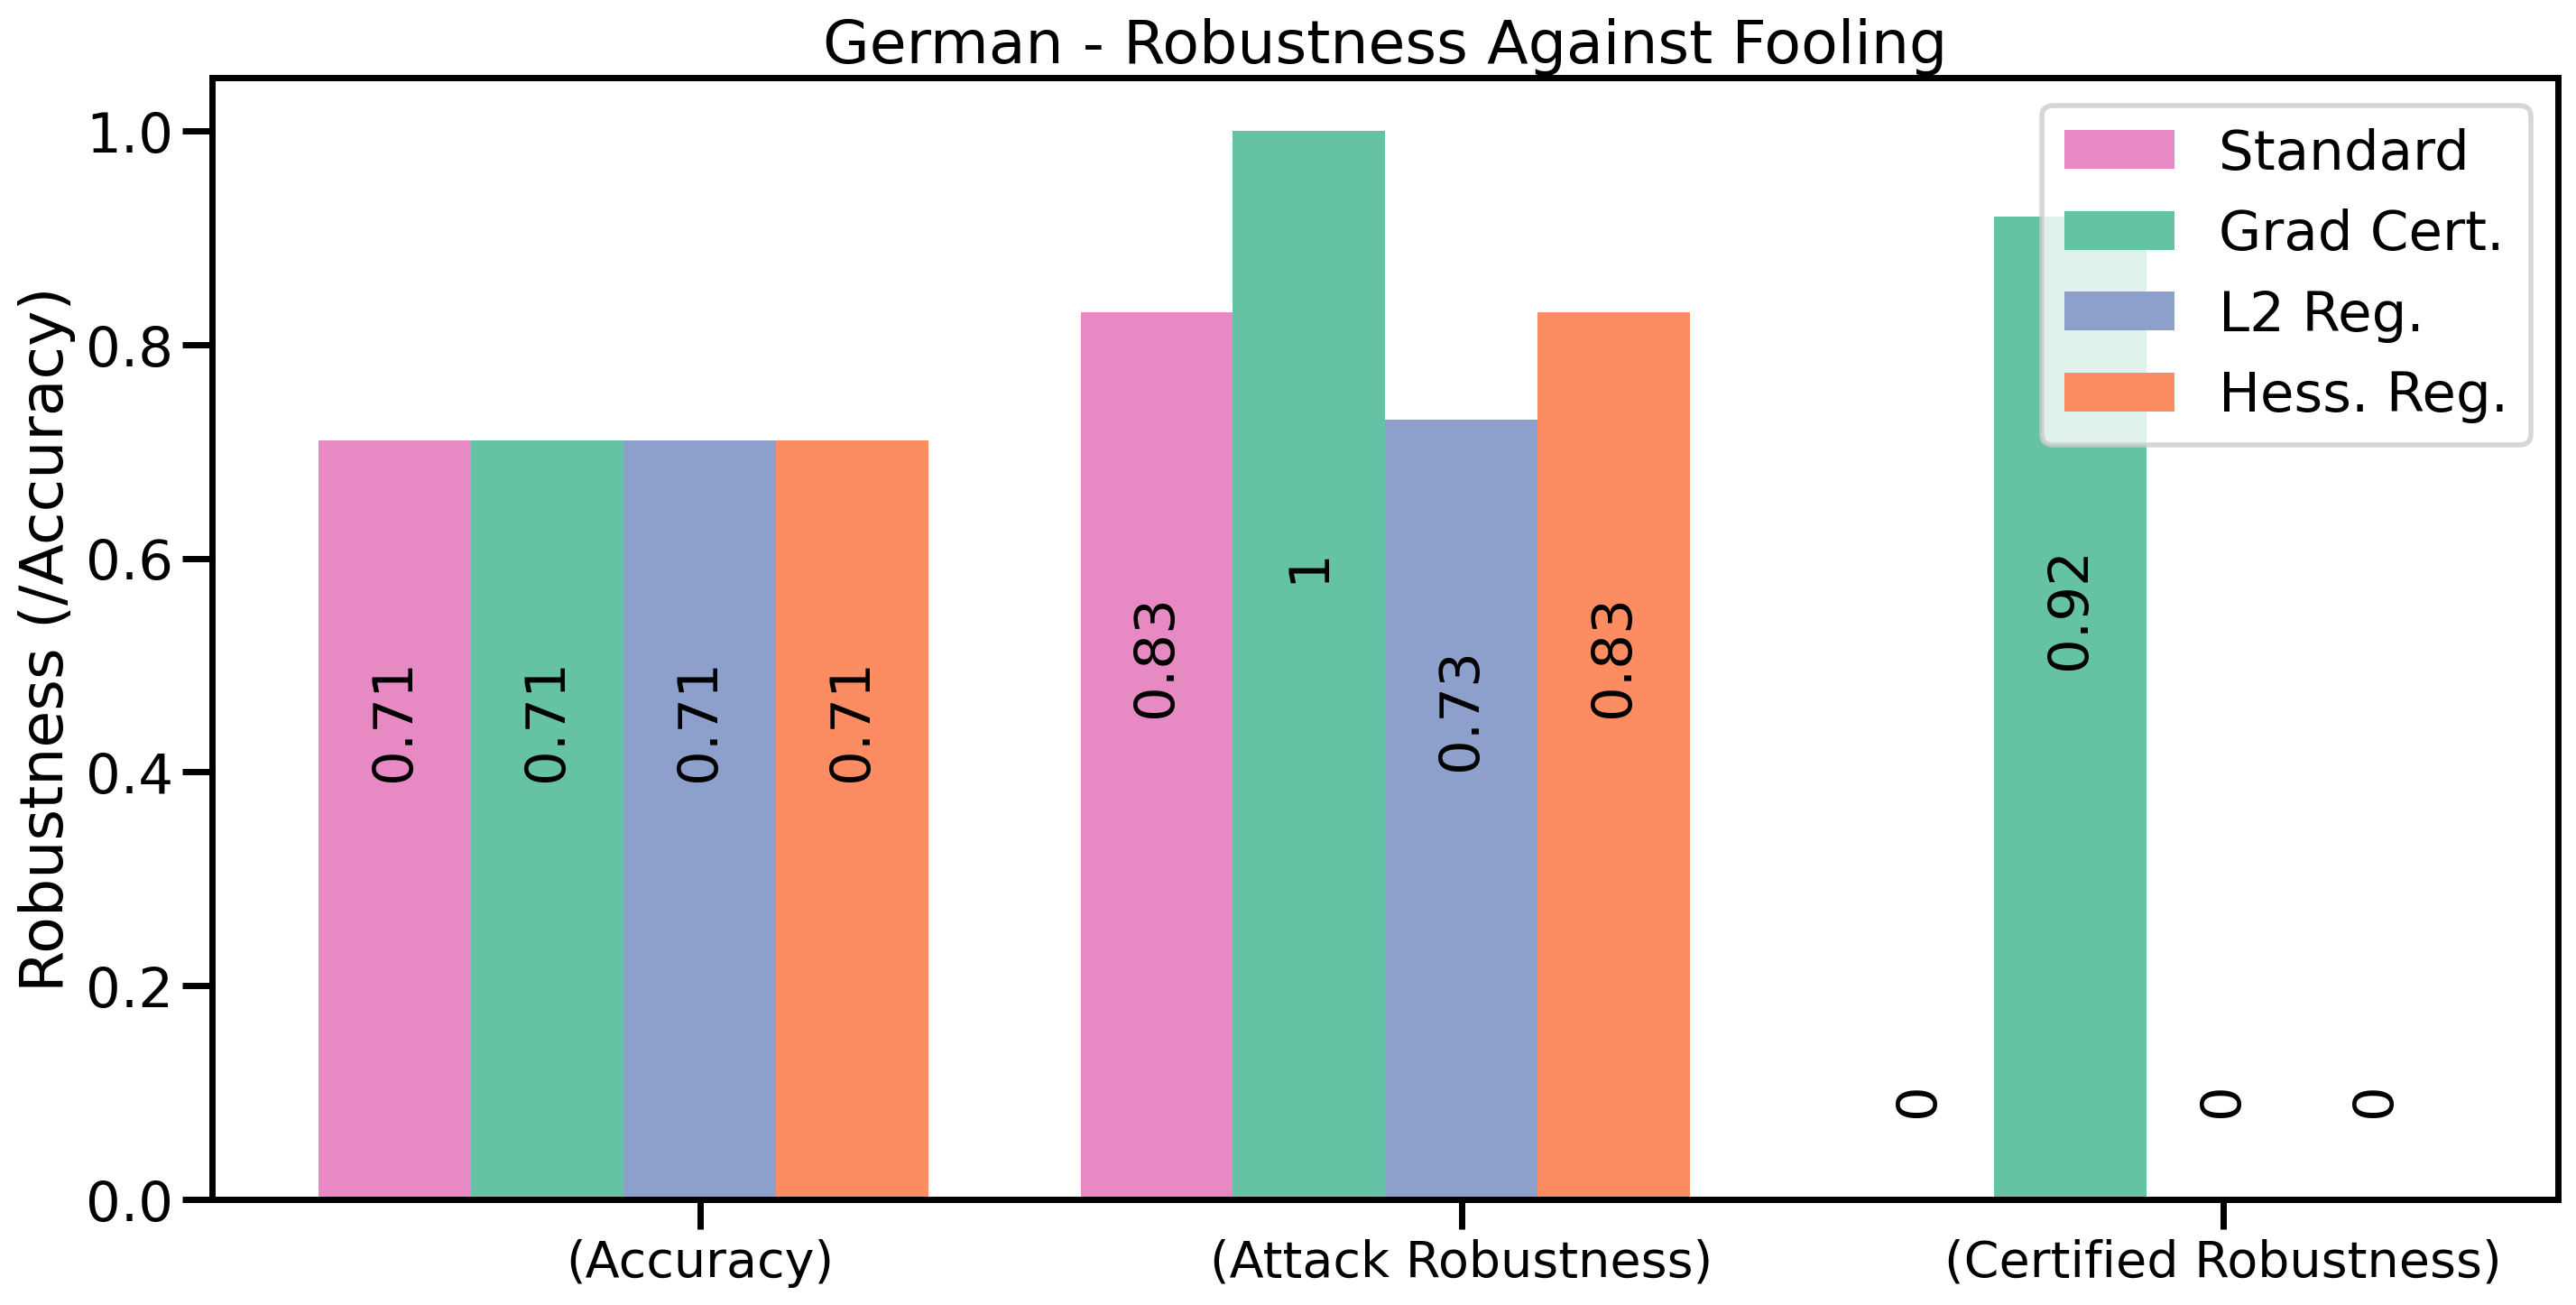

In [12]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

colors = sns.color_palette("Set2", 4)

std_vals = np.asarray([std_acc, 1-std_targ_inp_attk, std_targ_inp_cert])
std_vals = np.clip(std_vals, 0, 1)
std_vals = np.round(std_vals,2)

rob_vals = np.asarray([rob_acc, 1-rob_targ_inp_attk, rob_targ_inp_cert])
rob_vals = np.clip(rob_vals, 0, 1)
rob_vals = np.round(rob_vals,2)

el2_vals = np.asarray([el2_acc, 1-el2_targ_inp_attk, el2_targ_inp_cert])
el2_vals = np.clip(el2_vals, 0, 1)
el2_vals = np.round(el2_vals,2)

hes_vals = np.asarray([hes_acc, 1-hes_targ_inp_attk, hes_targ_inp_cert])
hes_vals = np.clip(hes_vals, 0, 1)
hes_vals = np.round(hes_vals,2)

x = np.arange(len(std_vals)) # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14,7), dpi=200)
rects1 = ax.bar(x - width*2, std_vals, width, label='Standard', color=colors[3], )
rects2 = ax.bar(x - width, rob_vals, width, label='Grad Cert.', color=colors[0])
rects3 = ax.bar(x + 0, el2_vals, width, label='L2 Reg.', color=colors[2])
rects4 = ax.bar(x + width, hes_vals, width, label='Hess. Reg.', color=colors[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
labels = ["(Accuracy)", "(Attack Robustness)", "(Certified Robustness)"]
ax.set_xticks(x, labels, size=20)
ax.legend()

ax.bar_label(rects1, padding=40, label_type='center', rotation = 90, size=22)
ax.bar_label(rects2, padding=40, label_type='center',  rotation = 90, size=22)
ax.bar_label(rects3, padding=40, label_type='center', rotation = 90, size=22)
ax.bar_label(rects4, padding=40, label_type='center',  rotation = 90, size=22)

plt.ylim((0,1.05))
fig.tight_layout()
plt.ylabel('Robustness (/Accuracy)')
plt.title("German - Robustness Against Fooling")
plt.show()



In [13]:
# Measure Input Attack Certification
def get_model_cert(MODEL_ID, GAM=0.2):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    import copy
    certified = 0
    for INDEX in trange(200):
        lower, upper = GradCertModule.GradCertBounds(model, torch.Tensor(X_test[INDEX][None, :]),
                                                     y_test[INDEX], eps=0.00, gam=GAM, nclasses=2)

        upper = np.squeeze(upper.detach().numpy())
        lower = np.squeeze(lower.detach().numpy())
        #print(upper[sens_inds])
        #print(lower[sens_inds])
        temp = copy.deepcopy(lower)
        for i in sens_inds:
            temp[i] = upper[i]
        #print(temp[sens_inds])
        top_idx = np.squeeze(np.argsort(temp))
        top_idx = list(reversed(top_idx))
        #print(set(top_idx[0:10]))
        #print( set(sens_inds))
        cert = not bool(set(top_idx[0:5]) & set(sens_inds))
        certified += int(cert)
        #break
    print(certified/200)
    return certified/200


M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_targ_mod_cert = get_model_cert(MODEL_ID, GAM=0.03)

M_ID = "GERMAN_FCN_e=0.0_g=0.05_a=1.0_l=2_h=256_s=True"
rob_targ_mod_cert = get_model_cert(M_ID, GAM=0.03)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_targ_mod_cert = get_model_cert(M_ID, GAM=0.03)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_targ_mod_cert = get_model_cert(M_ID, GAM=0.03)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 300.17it/s]


0.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 326.94it/s]


0.935


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 312.80it/s]


0.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 338.03it/s]

0.0


In [14]:
# Untargeted Input Attack 

# Measure Input Attack Robustness
from tqdm import trange
def get_untarg_attk(MODEL_ID, EPS=0.0, N=10):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    model.inputfooling_OFF()
    fooled = 0
    for INDEX in trange(N):
        success, x_adv, grad_adv = GradCertModule.run_tabular_attack(model, torch.Tensor(X_test[INDEX]), iterations=100,
                                                      target=-1, epsilon=EPS, lr=0.05)
        fooled += float(success)
        #print(success)
    model.inputfooling_OFF()
    print(fooled/N)
    return fooled/N
    #print("Input Attack Fooling Rate: ", fooled/5)
    
    
M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_utarg_inp_attk = get_untarg_attk(MODEL_ID, EPS=0.05, N=30)

M_ID = "GERMAN_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
rob_utarg_inp_attk = get_untarg_attk(M_ID, EPS=0.05, N=30)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_utarg_inp_attk = get_untarg_attk(M_ID, EPS=0.05, N=30)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_utarg_inp_attk = get_untarg_attk(M_ID, EPS=0.05, N=30)







  0%|                                                                                                                              | 0/30 [00:00<?, ?it/s]../../GradCertModule.py:693: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([1, 62])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_expl = -1*F.mse_loss(grad_adv, org_expl)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.32it/s]


0.3167854102717357


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.43it/s]


0.0180426973849535


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.37it/s]


0.08392679657166204


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.55it/s]

0.3167854102717357


In [15]:
# Untargeted Model Attack 

# Measure Model Attack Robustness
def get_model_untarg(MODEL_ID, GAM=0.5, N=10):
    fooled = 0
    for INDEX in trange(N):
        model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
        model.inputfooling_ON()
        #success, x_adv, grad_adv = GradCertModule.run_tabular_model_attack(model, torch.Tensor(X_test[INDEX]), iterations=150,
        #                                              target=sens_inds, gamma=GAM, lr=0.005*GAM, idx=7) 
        success, x_adv, grad_adv = GradCertModule.run_tabular_model_attack(model, torch.Tensor(X_test[INDEX]), iterations=50,
                                                      target=-1, gamma=GAM, lr=0.02, idx=7) 
        
        
        #print(grad_adv)
        fooled += float(success)
    model.inputfooling_OFF()  
    print(fooled/N)
    return fooled/N
    #print("Model Attack Fooling Rate: ", fooled/5)



#get_model_attk(MODEL_ID, GAM=0.01, N=10)


M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_utarg_mod_attk = get_model_untarg(M_ID, GAM=0.2, N=30)


M_ID = "GERMAN_FCN_e=0.0_g=0.05_a=1.0_l=2_h=256_s=True"
rob_utarg_mod_attk = get_model_untarg(M_ID, GAM=0.25, N=30)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_utarg_mod_attk = get_model_untarg(M_ID, GAM=0.25, N=30)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_utarg_mod_attk = get_model_untarg(M_ID, GAM=0.25, N=30)





  0%|                                                                                                                              | 0/30 [00:00<?, ?it/s]../../GradCertModule.py:778: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([1, 62])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_expl = -1*F.mse_loss(grad_adv, org_expl)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.62it/s]


0.8281386701390148


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.64it/s]


0.0057152975117787715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.69it/s]


0.06217465486067037


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.67it/s]

0.5430971866007894


In [16]:
def get_input_cert_untarg(MODEL_ID, EPS=0.2):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    import copy
    certified = 0
    for INDEX in trange(200):
        lower, upper = GradCertModule.GradCertBounds(model, torch.Tensor(X_test[INDEX][None, :]),
                                                     y_test[INDEX], eps=EPS, gam=0.00, nclasses=2)

        upper = np.squeeze(upper.detach().numpy())
        lower = np.squeeze(lower.detach().numpy())
        diff = np.mean(upper-lower)
        certified += float(diff)
        #break
    #print("Input Attack Certified: ", certified/200)
    print(certified/200)
    return certified/200

M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_utarg_inp_cert = get_input_cert_untarg(MODEL_ID, EPS=0.05)

M_ID = "GERMAN_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
rob_utarg_inp_cert = get_input_cert_untarg(M_ID, EPS=0.05)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_utarg_inp_cert = get_input_cert_untarg(M_ID, EPS=0.05)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_utarg_inp_cert = get_input_cert_untarg(M_ID, EPS=0.05)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 586.82it/s]


17921.567197265624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 656.82it/s]


0.0025417730884487355


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 633.77it/s]


394.55719482421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 670.18it/s]

17921.567197265624


In [17]:

def get_model_cert(MODEL_ID, GAM=0.2):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    import copy
    certified = 0
    for INDEX in trange(200):
        lower, upper = GradCertModule.GradCertBounds(model, torch.Tensor(X_test[INDEX][None, :]),
                                                     y_test[INDEX], eps=0.00, gam=GAM, nclasses=2)

        upper = np.squeeze(upper.detach().numpy())
        lower = np.squeeze(lower.detach().numpy())
        diff = np.mean(upper-lower)
        certified += float(diff)
        #break
    print(certified/200)
    return certified/200

M_ID = "GERMAN_FCN_e=0.0_g=0.0_a=1.0_l=2_h=256_s=True"
std_utarg_mod_cert = get_model_cert(MODEL_ID, GAM=0.03)

M_ID = "GERMAN_FCN_e=0.0_g=0.05_a=1.0_l=2_h=256_s=True"
rob_utarg_mod_cert = get_model_cert(M_ID, GAM=0.03)

M_ID = "GERMAN_L2_FCN_e=0.05_g=0.0_a=1.0_l=2_h=256_s=True"
el2_utarg_mod_cert = get_model_cert(M_ID, GAM=0.03)

M_ID = "GERMAN_HESSIAN_FCN_e=0.05_g=0.0_a=0.1_l=2_h=256_s=True"
hes_utarg_mod_cert = get_model_cert(M_ID, GAM=0.03)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 575.07it/s]


1553.2872309875488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 667.02it/s]


0.0015522249035393543


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 622.10it/s]


44.274057445526125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 711.22it/s]

1553.2872309875488


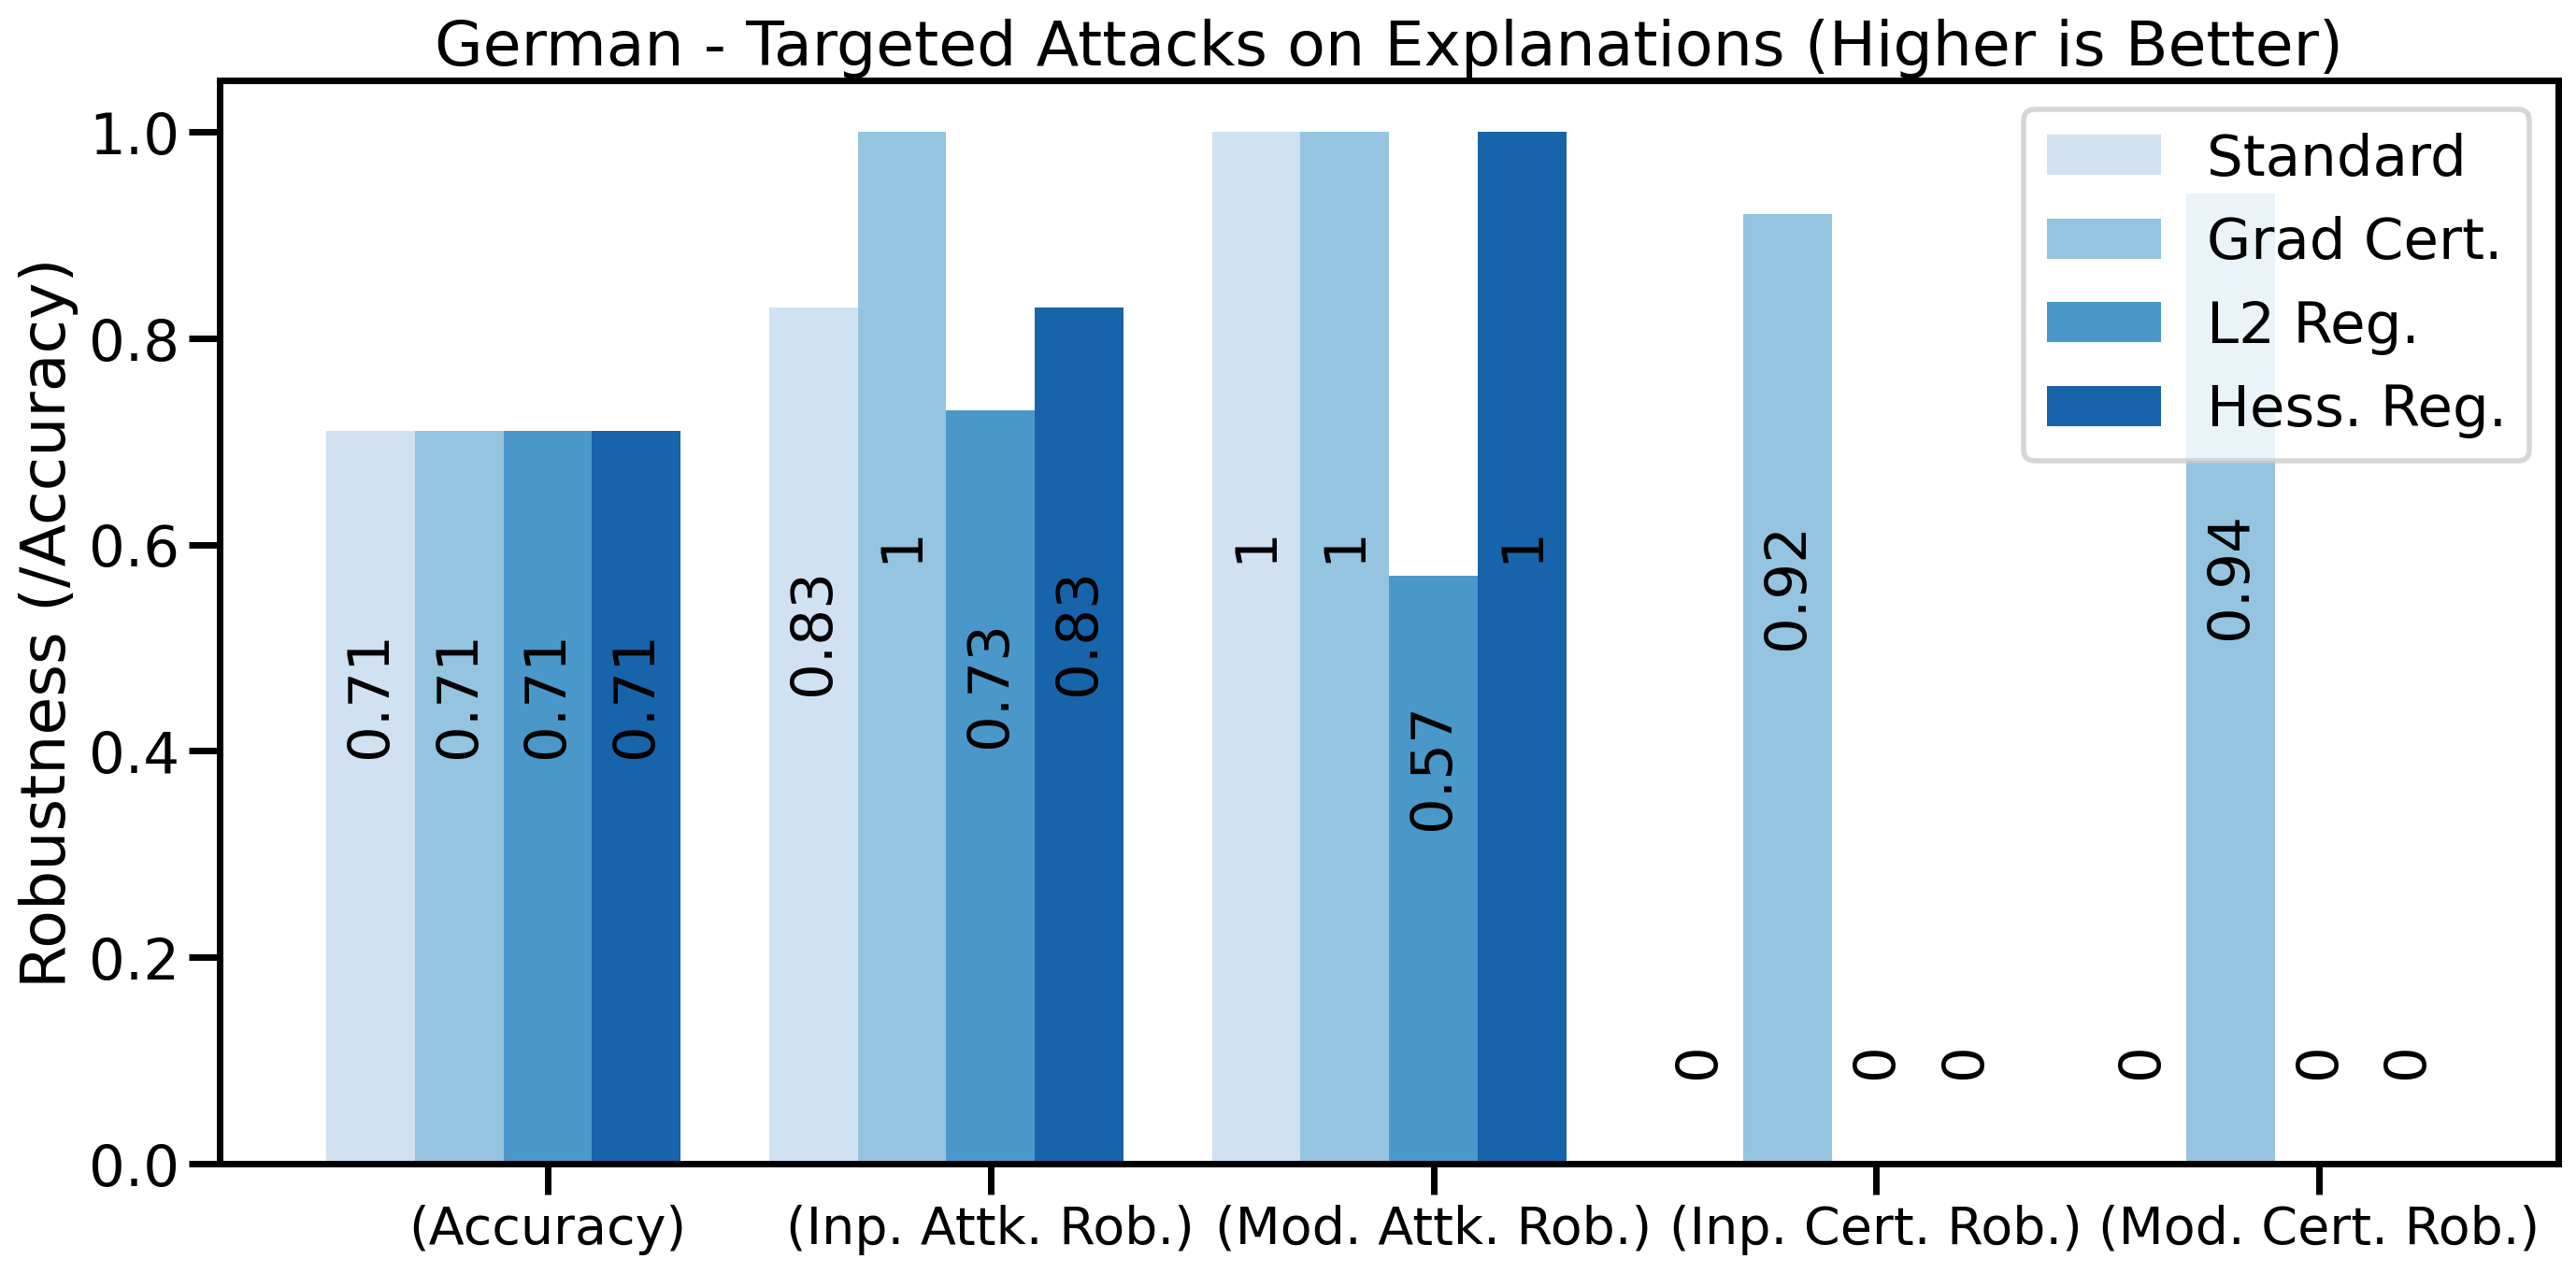

In [18]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

colors = sns.color_palette("Blues", 4)

std_vals = np.asarray([std_acc, 1-std_targ_inp_attk, 1-std_targ_mod_attk, 
            std_targ_inp_cert, std_targ_mod_cert])
std_vals = np.clip(std_vals, 0, 1)
std_vals = np.round(std_vals,2)

rob_vals = np.asarray([rob_acc, 1-rob_targ_inp_attk, 1-rob_targ_mod_attk, 
            rob_targ_inp_cert, rob_targ_mod_cert])
rob_vals = np.clip(rob_vals, 0, 1)
rob_vals = np.round(rob_vals,2)

el2_vals = np.asarray([el2_acc, 1-el2_targ_inp_attk, 1-el2_targ_mod_attk, 
            el2_targ_inp_cert, el2_targ_mod_cert])
el2_vals = np.clip(el2_vals, 0, 1)
el2_vals = np.round(el2_vals,2)

hes_vals = np.asarray([hes_acc, 1-hes_targ_inp_attk, 1-hes_targ_mod_attk, 
            hes_targ_inp_cert, hes_targ_mod_cert])
hes_vals = np.clip(hes_vals, 0, 1)
hes_vals = np.round(hes_vals,2)

x = np.arange(len(std_vals))*1.00  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14,7), dpi=200)
rects1 = ax.bar(x - width*2, std_vals, width, label='Standard', color=colors[0], )
rects2 = ax.bar(x - width, rob_vals, width, label='Grad Cert.', color=colors[1])
rects3 = ax.bar(x + 0, el2_vals, width, label='L2 Reg.', color=colors[2])
rects4 = ax.bar(x + width, hes_vals, width, label='Hess. Reg.', color=colors[3])

# Add some text for labels, title and custom x-axis tick labels, etc.
labels = ["(Accuracy)", "(Inp. Attk. Rob.)", "(Mod. Attk. Rob.)", "(Inp. Cert. Rob.)", "(Mod. Cert. Rob.)"]
ax.set_xticks(x, labels, size=20)
ax.legend()

ax.bar_label(rects1, padding=40, label_type='center', rotation = 90, size=22)
ax.bar_label(rects2, padding=40, label_type='center',  rotation = 90, size=22)
ax.bar_label(rects3, padding=40, label_type='center', rotation = 90, size=22)
ax.bar_label(rects4, padding=40, label_type='center',  rotation = 90, size=22)

plt.ylim((0,1.05))
fig.tight_layout()
plt.ylabel('Robustness (/Accuracy)')
plt.title("German - Targeted Attacks on Explanations (Higher is Better)")
plt.show()



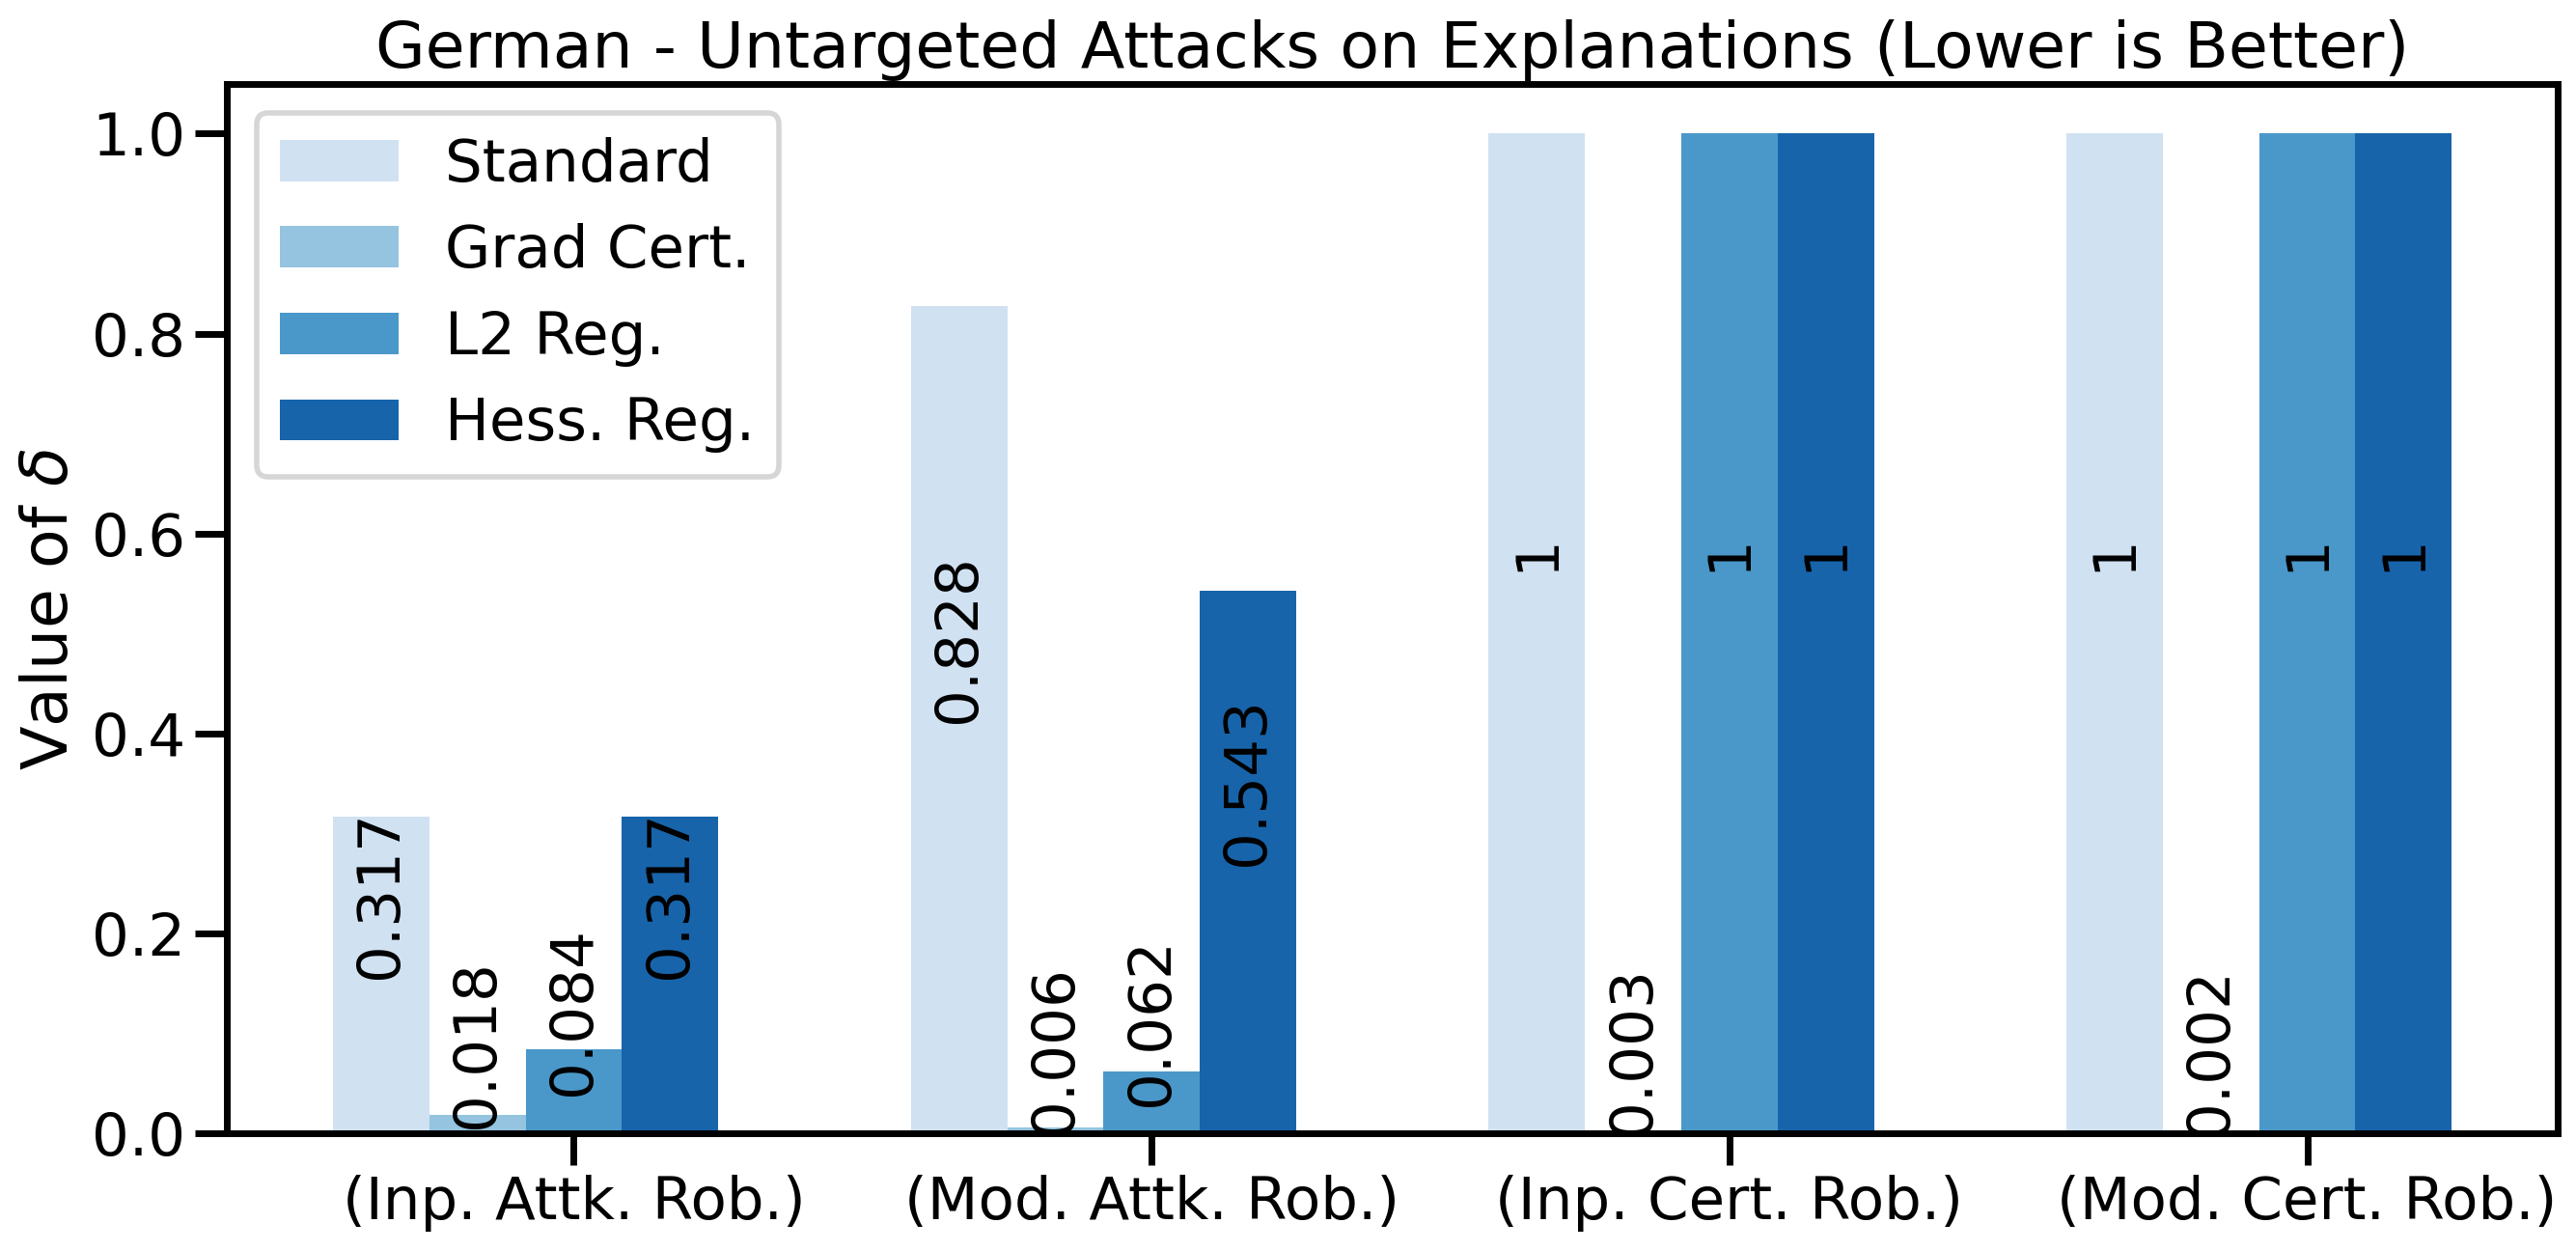

In [19]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

colors = sns.color_palette("Blues", 4)

std_vals = np.asarray([ std_utarg_inp_attk, std_utarg_mod_attk, 
            std_utarg_inp_cert, std_utarg_mod_cert])
std_vals = np.clip(std_vals, 0, 1)
std_vals = np.round(std_vals,3)

rob_vals = np.asarray([rob_utarg_inp_attk, rob_utarg_mod_attk, 
            rob_utarg_inp_cert, rob_utarg_mod_cert])
rob_vals = np.clip(rob_vals, 0, 1)
rob_vals = np.round(rob_vals,3)

el2_vals = np.asarray([el2_utarg_inp_attk, el2_utarg_mod_attk, 
            el2_utarg_inp_cert, el2_utarg_mod_cert])
el2_vals = np.clip(el2_vals, 0, 1)
el2_vals = np.round(el2_vals,3)

hes_vals = np.asarray([hes_utarg_inp_attk, hes_utarg_mod_attk, 
            hes_utarg_inp_cert, hes_utarg_mod_cert])
hes_vals = np.clip(hes_vals, 0, 1)
hes_vals = np.round(hes_vals,3)

x = np.arange(len(std_vals))*1.5  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(14,7), dpi=200)
rects1 = ax.bar(x - width*2, std_vals, width, label='Standard', color=colors[0], )
rects2 = ax.bar(x - width, rob_vals, width, label='Grad Cert.', color=colors[1])
rects3 = ax.bar(x + 0, el2_vals, width, label='L2 Reg.', color=colors[2])
rects4 = ax.bar(x + width, hes_vals, width, label='Hess. Reg.', color=colors[3])

# Add some text for labels, title and custom x-axis tick labels, etc.
labels = ["(Inp. Attk. Rob.)", "(Mod. Attk. Rob.)", "(Inp. Cert. Rob.)", "(Mod. Cert. Rob.)"]
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=30, label_type='center', rotation = 90, size=22)
ax.bar_label(rects2, padding=30, label_type='center',  rotation = 90, size=22)
ax.bar_label(rects3, padding=30, label_type='center', rotation = 90, size=22)
ax.bar_label(rects4, padding=30, label_type='center',  rotation = 90, size=22)

plt.title("German - Untargeted Attacks on Explanations (Lower is Better)")
plt.ylabel(r"Value of $\delta$")
plt.ylim((0,1.05))
fig.tight_layout()
plt.show()



In [20]:
asdf = asdf

NameError: name 'asdf' is not defined

In [ ]:
# Measure Input Attack Certification
def get_model_cert(MODEL_ID, GAM=0.2):
    model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
    import copy
    certified = 0
    for INDEX in trange(200):
        lower, upper = GradCertModule.GradCertBounds(model, torch.Tensor(X_test[INDEX][None, :]),
                                                     y_test[INDEX], eps=0.00, gam=GAM, nclasses=2)

        upper = np.squeeze(upper.detach().numpy())
        lower = np.squeeze(lower.detach().numpy())
        #print(upper[sens_inds])
        #print(lower[sens_inds])
        temp = copy.deepcopy(lower)
        for i in sens_inds:
            temp[i] = upper[i]
        #print(temp[sens_inds])
        top_idx = np.squeeze(np.argsort(temp))
        top_idx = list(reversed(top_idx))
        #print(set(top_idx[0:10]))
        #print( set(sens_inds))
        cert = not bool(set(top_idx[0:5]) & set(sens_inds))
        certified += int(cert)
        #break
    return certified/200
    #print("Model Attack Certified: ", certified/200)
get_model_cert(MODEL_ID)

In [ ]:
# Measure Joint Attack Certification
model.load_state_dict(torch.load('Models/%s.pt'%(MODEL_ID)))
import copy
certified = 0
for INDEX in trange(200):
    lower, upper = GradCertModule.GradCertBounds(model, torch.Tensor(X_test[INDEX][None, :]),
                                                 y_test[INDEX], eps=0.2, gam=0.2, nclasses=2)
    
    upper = np.squeeze(upper.detach().numpy())
    lower = np.squeeze(lower.detach().numpy())
    #print(upper[sens_inds])
    #print(lower[sens_inds])
    temp = copy.deepcopy(lower)
    for i in sens_inds:
        temp[i] = upper[i]
    #print(temp[sens_inds])
    top_idx = np.squeeze(np.argsort(temp))
    top_idx = list(reversed(top_idx))
    #print(set(top_idx[0:10]))
    #print( set(sens_inds))
    cert = not bool(set(top_idx[0:5]) & set(sens_inds))
    certified += int(cert)
    #break
print("Joint Attack Certified: ", certified/200)

In [ ]:
# Measure Certified Adversarial Robustness

robust = 0
for INDEX in trange(len(X_test)):
    data = torch.Tensor([X_test[INDEX]])
    out, cls = model.classify(data)
    y_l, y_u = GradCertModule.RobustnessBounds(model, data, cls, eps=0.1, gam=0.0, nclasses=2)
    y_l, y_u = np.squeeze(y_l.detach().numpy()), np.squeeze(y_u.detach().numpy())
    y = y_u
    y[cls] = y_l[cls]
    worst_case = np.argmax(y)
    if(cls == y_test[INDEX]):
        robust += 1 
robust /= len(X_test)
print("Certified Adversarial Robustness: ", robust)



In [ ]:
def gen_model_id(GAM_T=0.0, EPS_T=0.0):

    ALPHA = 1.0            # Regularization Parameter (Weights the Reg. Term)
    EPSILON = EPS_T         # Input Peturbation Budget at Training Time

    LEARN_RATE = 0.0005     # Learning Rate Hyperparameter
    HIDDEN_DIM = 256       # Hidden Neurons Hyperparameter
    HIDDEN_LAY = 2         # Hidden Layers Hyperparameter
    MAX_EPOCHS = 25

    EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
    GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?
    
    MODEL_ID = "%s_FCN_e=%s_g=%s_a=%s_l=%s_h=%s_s=%s"%(dataset, EPSILON, GAM_T, ALPHA, HIDDEN_LAY, HIDDEN_DIM, SCHEDULED)     
    print(MODEL_ID)
    return MODEL_ID


    

In [ ]:


CERT_VALS = []
eps_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
for eps in eps_vals:
    M_ID = gen_model_id(EPS_T=eps)
    val = []
    for e_test in np.linspace(0, 0.2, 20): #[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
        certified = get_input_cert(M_ID, EPS=e_test)
        val.append(certified)
    #print("*****")
    #print(gam, val)
    #print("*****")
    CERT_VALS.append(val)
    
    


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)


eps_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
g_test = [0.0, 0.01, 0.02, 0.03, 0.05, 0.06]

pal = sns.cubehelix_palette(n_colors=len(eps_vals), start=.5, rot=-.75)
print(pal.as_hex())

for i in range(len(eps_vals)):
    print(CERT_VALS[i])
    plt.plot(CERT_VALS[i], label=eps_vals[i], 
             color=pal[i], linewidth=10)
plt.legend()
ax = plt.gca()
ax.set_xticks([0,4,9,14,19])
labs = [round(i, 2) for i in np.linspace(0, 0.2, 5)]
ax.set_xticklabels(labs)
#ax.set_xticklabels(g_test)
plt.title("%s"%(dataset))
plt.ylabel("Input Certified Robustness")
plt.xlabel(r"Magnitude of $\epsilon$")
ax.get_legend().set_title(r"$\epsilon_t$")
plt.show()


In [ ]:

CERT_VALS = []
if(dataset == "ADULT"):
    gam_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
    #gamma_vals = [0.0, 0.01, 0.02, 0.03, 0.05]
#else:
#    gam_vals = [0.0, 0.0125, 0.025, 0.05, 0.075, 0.125]
for gam in gam_vals:
    M_ID = gen_model_id(gam)
    val = []
    for g_test in np.linspace(0, 0.1, 20): #[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
        certified = get_model_cert(M_ID, GAM=g_test)
        val.append(certified)
    print("*****")
    print(gam, val)
    print("*****")
    CERT_VALS.append(val)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)

# These values are different because of the logit softmax
# comutation that we used to do vs what we do now given 
# That it was an error before. Just correct this when running plots

if(dataset == "ADULT"):
    gamma_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
    g_test = [0.0, 0.01, 0.02, 0.03, 0.05, 0.06]
#else:
#    g_test = [0.0, 0.05, 0.1, 0.15, 0.2]
#    gamma_vals = [0.0, 0.0125, 0.025, 0.05, 0.075, 0.125]
pal = sns.cubehelix_palette(n_colors=len(gamma_vals), start=.5, rot=-.75)
print(pal.as_hex())

for i in range(len(gam_vals)):
    print(CERT_VALS[i])
    plt.plot(CERT_VALS[i], label=gamma_vals[i], 
             color=pal[i], linewidth=10)
plt.legend()
ax = plt.gca()
ax.set_xticks([0,4,9,14,19])
labs = [round(i, 2) for i in np.linspace(0, 0.1, 5)]
ax.set_xticklabels(labs)
plt.title("%s"%(dataset))
plt.ylabel("Model Certified Robustness")
plt.xlabel(r"Magnitude of $\gamma$")
ax.get_legend().set_title(r"$\gamma_t$")
plt.show()

In [ ]:
ATTK_VALS = []

eps_vals =  [0.00, 0.01, 0.02, 0.03, 0.04, 0.05]

for eps in eps_vals:
    M_ID = gen_model_id(0.0, EPS_T = eps)
    val = []
    for e_test in [0.0, 0.05, 0.1, 0.15, 0.20]:
        certified = get_input_attk(M_ID, EPS=e_test, N=35)
        print(certified)
        val.append(certified)
    print("*****")
    print(eps, val)
    print("*****")
    ATTK_VALS.append(val)
    
    

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)


eps_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
e_test_vals = [0.01, 0.05, 0.075, 0.1, 0.125, 0.175]

pal = sns.cubehelix_palette()
pal = pal.as_hex()
pal = [i for i in reversed(pal)]
print(pal)
#print(pal.as_hex())

for i in range(len(eps_vals)):
    plt.plot(1-np.asarray(ATTK_VALS[i]), label=eps_vals[i], color=pal[i], linewidth=10)
plt.legend()
ax = plt.gca()

ax.set_xticks(range(len(e_test_vals)))
ax.set_xticklabels(e_test_vals)

plt.title("%s"%(dataset))
plt.ylabel("Input Attack Robustness")
plt.xlabel(r"Magnitude of $\epsilon$")
ax.get_legend().set_title(r"$\epsilon_t$")

plt.show()

In [ ]:
"""
ATTK_VALS = []

gam_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

for gam in gam_vals:
    M_ID = gen_model_id(gam)
    val = []
    for g_test in [0.01, 0.05, 0.075, 0.1, 0.125, 0.175]:
        certified = get_model_attk(M_ID, GAM=g_test, N=35)
        print(certified)
        val.append(certified)
    print("*****")
    print(gam, val)
    print("*****")
    ATTK_VALS.append(val)
"""   

In [ ]:
print(ATTK_VALS)

ATTK_VALS = [[0.2, 0.5714285714285714, 0.6, 0.6571428571428571, 0.7142857142857143, 0.8],
             [0.0, 0.0, 0.0, 0.0, 0.17142857142857143, 0.4], 
             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)


gam_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
g_test_vals = [0.05, 0.075, 0.1, 0.125, 0.15]

pal = sns.cubehelix_palette()
pal = pal.as_hex()
pal = [i for i in reversed(pal)]
print(pal)
#print(pal.as_hex())

for i in range(len(gam_vals)):
    plt.plot(1-np.asarray(ATTK_VALS[i]), label=gam_vals[i], color=pal[i], linewidth=10)
plt.legend()
ax = plt.gca()

ax.set_xticks(range(len(g_test_vals)))
ax.set_xticklabels(g_test_vals)

plt.title("%s"%(dataset))
plt.ylabel("Model Attack Robustness")
plt.xlabel(r"Magnitude of $\gamma$")
ax.get_legend().set_title(r"$\gamma_t$")

plt.show()

In [ ]:
print(ATTK_VALS)
ATTK_VALS = [[0.2, 0.5714285714285714, 0.6, 0.6571428571428571, 0.7142857142857143, 0.8],
             [0.0, 0.0, 0.0, 0.0, 0.17142857142857143, 0.4], 
             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

